In [9]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
from dotenv import load_dotenv
from statsmodels.tsa.stattools import adfuller
from research.pipes.sql import SQLPipe
from research.utils import test_trading_liquidity

pd.options.display.float_format = '{:,.4f}'.format

load_dotenv()

USER = os.getenv('PSQL_USERNAME')
PASS = os.getenv('PSQL_PASSWORD')
DATABASE = 'crypto'
SCHEMA = 'hourly'
INTERVAL = '60T'

pipe = SQLPipe(SCHEMA, DATABASE, USER, PASS, INTERVAL)

In [10]:
# This will take a bit to run
vol = test_trading_liquidity(interval='1hour')
vol.to_csv('data/vol.csv')

In [25]:
data = pd.read_csv("data/18M30T.csv", index_col=0)

# vol = pd.read_csv('data/vol.csv', index_col=0)
low_vol = vol[vol < 25_000].index.to_list()
low_vol = [symbol.lower().replace("-","") for symbol in low_vol]

data = data[data["pvalue"] < 0.01]
data = data[data["hurst"] < 0.50]
data = data[~data['x'].isin(low_vol) & ~data['y'].isin(low_vol)]
excluded_values = []
data = data[~data['x'].isin(excluded_values) & ~data['y'].isin(excluded_values)]
data['compound_score'] = data['pvalue'] * data['hurst'] * data['halflife']

data = data.sort_values('compound_score').reset_index(drop=True)

data.head(25)

,x,y,tscore,pvalue,hurst,halflife,compound_score
0,dotusdt,vrausdt,-6.6723,0.0000,0.4188,180.8548,0.0000
1,injusdt,pyrusdt,-5.9634,0.0000,0.4242,241.3183,0.0002
2,injusdt,kdausdt,-5.8049,0.0000,0.4598,359.7377,0.0007
3,vetusdt,xlmusdt,-5.5728,0.0000,0.4199,238.1172,0.0013
4,hbarusdt,vrausdt,-5.5450,0.0000,0.4374,236.2014,0.0015
5,thetausdt,filusdt,-5.3712,0.0000,0.4334,287.7529,0.0040
6,injusdt,bnbusdt,-5.3303,0.0000,0.4320,250.3569,0.0042
7,xrpusdt,injusdt,-5.2681,0.0001,0.4155,210.7431,0.0045
8,injusdt,shibusdt,-5.3278,0.0000,0.4710,270.7590,0.0050
9,qntusdt,aptusdt,-4.8467,0.0003,0.3825,53.8259,0.0064


In [17]:
i = 18
x = data.loc[i, "x"]
y = data.loc[i, "y"]
df = pipe.query_pairs_trading_backtest([x, y])
print(x,y)

injusdt egldusdt


In [18]:
closes = np.log(df.xs(
    "close", level=1, axis=1
).rename(columns={0: x, 1: y}))

(10502,)


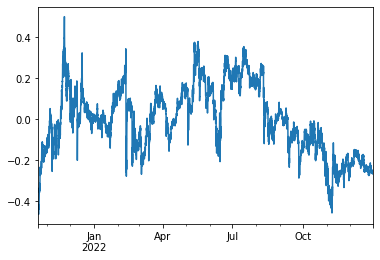

In [23]:
slicer = -13420

res = sm.OLS(
    endog=closes.iloc[slicer:, 1],
    exog=sm.add_constant(closes.iloc[slicer:, 0]),
).fit()

res.resid.plot()
print(res.resid.shape)

-0.6135603267139369 -0.039846660824942454


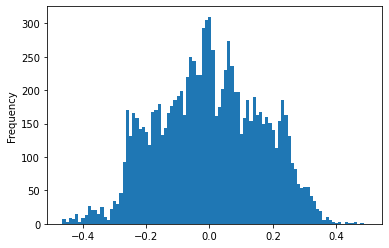

In [20]:
bins = np.arange(res.resid.min(), res.resid.max(), 0.01)
res.resid.plot(kind='hist', bins=bins)
print(kurtosis(res.resid), skew(res.resid))

In [21]:
def engle_granger(resids, level="1%", maxlag=1):
    test_results = adfuller(resids, maxlag=maxlag, regression="n")

    interpretation = test_results[0] < test_results[4][level]

    print("-------- Results ---------")
    print(f"Stationary at {level} confidence? {interpretation}")
    print(f"Critical value: {test_results[4][level]:.4f}")
    print(f"t-score for test: {test_results[0]:.4f}")
    print(f"p-score for test: {test_results[1]:.4f}")

engle_granger(res.resid)

-------- Results ---------
Stationary at 1% confidence? True
Critical value: -2.5660
t-score for test: -4.5361
p-score for test: 0.0000
